# Stock Forecasting using Markov Switching Model

## Package Imports

In [8]:
from datetime import datetime
import pandas as pd
import numpy as np
import pydtmc
import yfinance as yf

## Defining Constants

In [3]:
# define ticker
ticker = "TSLA"
# today
today = datetime.today().strftime("%Y-%m-%d")
# 1000 days ego
start = (datetime.today() - pd.Timedelta(days=1000)).strftime("%Y-%m-%d")
# get TSLA data from start to today
data_raw = yf.download(ticker, start=start, end=today, progress=False)

In [4]:

# get TSLA data from start to today
data_raw = yf.download(ticker, start=start, end=today, progress=False)
data_raw = yf.download(ticker, start=start, end=today, progress=False)
# filter Adj Close column and compute daily return
data = data_raw[["Adj Close"]].copy()
data.loc[:, "Return"] = data["Adj Close"].pct_change()
data = data[1:]

In [5]:
# define 3 states for the `Return` column: Bull, Bear and Cons
data.loc[:, "State"] = pd.cut(
    data["Return"],
    bins=[-np.inf, -0.001, 0.001, np.inf],
    labels=["Bear", "Cons", "Bull"],
)
# add `priorState` column
data.loc[:, "priorState"] = data["State"].shift(1)
# drop nan values
data = data.dropna()
# define states_matrix based on `State` and `priorState` columns
states_matrix = pd.crosstab(data["priorState"], data["State"], normalize="index")

In [6]:
states_matrix

State,Bear,Cons,Bull
priorState,,,
Bear,0.458861,0.018987,0.522152
Cons,0.461538,0.076923,0.461538
Bull,0.460894,0.016760,0.522346


In [81]:
# create a markov chain based on states_matrix
mc = pydtmc.MarkovChain(states_matrix.values, states_matrix.index.tolist())
# print mc attributes
print("model absorbing states:", mc.absorbing_states)
print("is model ergodic?", mc.is_ergodic)
print("model recurrent states:", mc.recurrent_states)
print("model transient states:", mc.transient_states)
print("model steady state:", mc.steady_states)

model absorbing states: []
is model ergodic? True
model recurrent states: ['Bear', 'Cons', 'Bull']
model transient states: []
model steady state: [array([0.46131387, 0.0189781 , 0.51970803])]


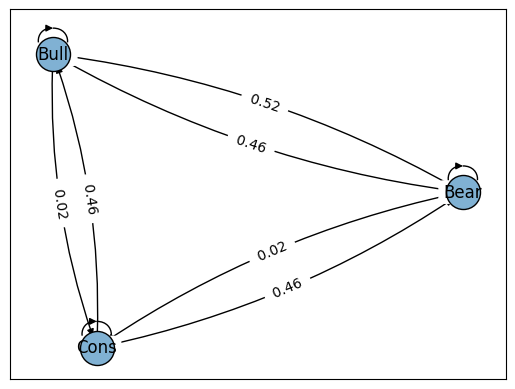

In [82]:
# plot the transition graph
pydtmc.plot_graph(mc)

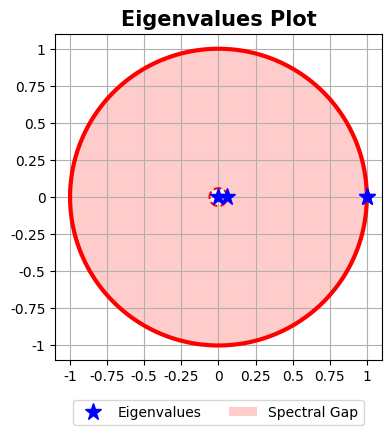

In [59]:
# plot eigenvalues
pydtmc.plot_eigenvalues(mc)

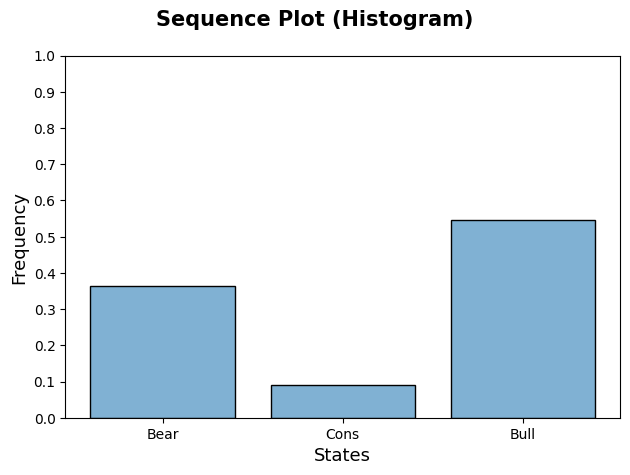

In [60]:
# plot sequences in histogram
pydtmc.plot_sequence(mc, 10, plot_type="histogram")

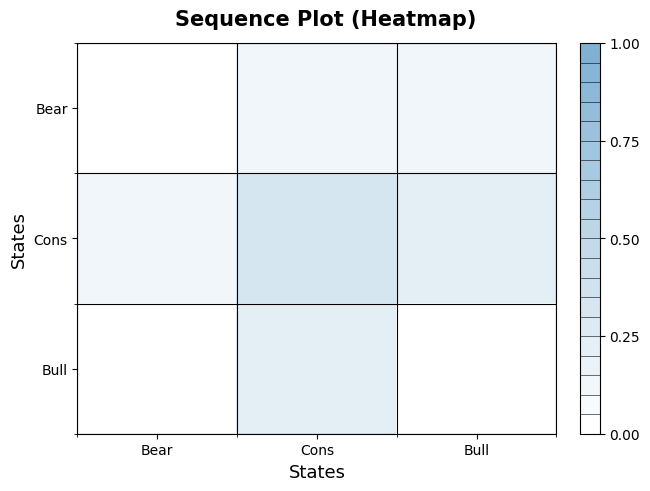

In [51]:
# plot sequences in heatmap
pydtmc.plot_sequence(mc, 10, plot_type="heatmap")

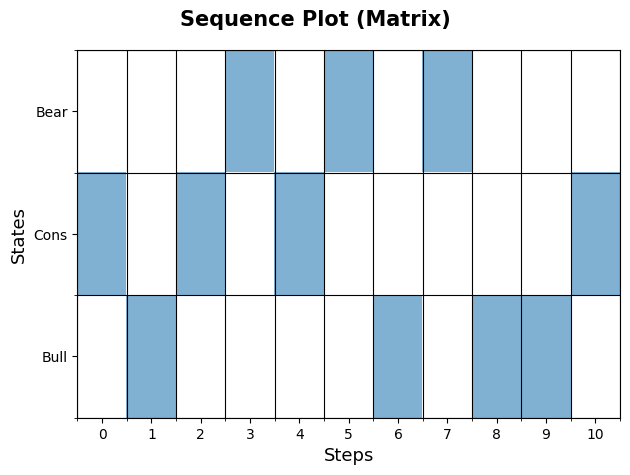

In [52]:
# plot sequqnces in matrix
pydtmc.plot_sequence(mc, 10, plot_type="matrix")

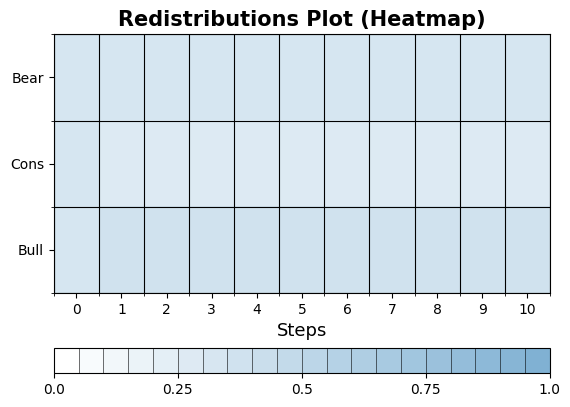

In [54]:
# plot redistribution in heatmap
pydtmc.plot_redistributions(mc, 10, plot_type="heatmap")

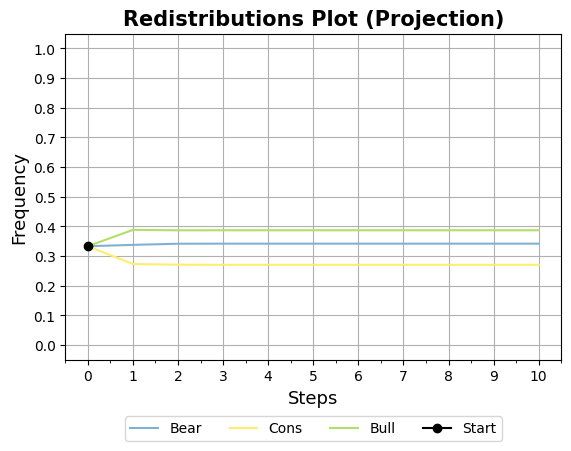

In [55]:
# plot redistributions in projection
pydtmc.plot_redistributions(mc, 10, plot_type="projection")